In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
import scipy.io 
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from tqdm import tqdm

mat = scipy.io.loadmat('Task2.mat')
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'A', 'Image'])


**Load the input**

In [5]:
A = mat['A']
image = mat['Image']
A = A.reshape((25, 256))              # flatten the input image and DCT
image = image.reshape((25,))

print(A.shape)
print(image.shape)

(25, 256)
(25,)


In [25]:
m= 500
N= 10000
y= np.random.randn(m,1)
A= np.random.randn(m,N)

In [31]:
def omp(y, A, sparsity):
    m,N = A.shape
    res= y
    set_ys= np.zeros((m, 1))
    indices=[]
    A/=np.linalg.norm(A, ord=2, axis=0)
    solution= np.zeros((A.shape[1],1))

    for i in tqdm(range(sparsity), total=sparsity):
        corr_coeffs= abs(A.T@y)
        index= np.argmax(corr_coeffs)
        while index in indices:
            corr_coeffs= np.delete(corr_coeffs, index)
            index= np.argmax(corr_coeffs)
        indices.append(index)
        set_ys= A[:,indices]
        solution[indices] = np.linalg.pinv(set_ys).dot(y)
        res = res - A.dot(solution)
    
    return solution

100%|██████████| 500/500 [00:57<00:00,  8.64it/s]


(10000, 1)


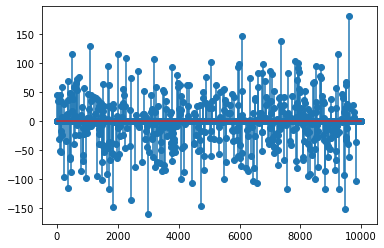

In [32]:
res= omp(y, A, 500)
plt.stem(res)
print(res.shape)

500.0

**ORTHOGONAL MATCHING PURSUIT ALGORITHM**

In [40]:
def OMP(A, y, non_zero_terms):
  residue = y
  x = np.zeros(A.shape[1])
  
  for i in range(non_zero_terms):
    dot = np.dot(A.T, residue)            # dot product of all columns of A with y
    dot = dot.reshape((-1,))        

    index = np.argmax(np.abs(dot))        # consider maximum dot product(atom with strongest influence) and ensure that already considered atom in not considered again
    print(dot.shape)
    print(residue.shape)
    print()
    while(x[index] != 0): 
      dot[index] = 0
      index = np.argmax(np.abs(dot))

    x[index] = dot[index]                           # update x
    residue = residue - dot[index] * A[:, index]    # update the residue
  
  return x

**Sparse encoding**

In [41]:
non_zero_terms = 20

x = OMP(A, y, non_zero_terms)

(100,)
(50, 1)

(5000,)
(50, 50)



IndexError: index 4189 is out of bounds for axis 0 with size 100

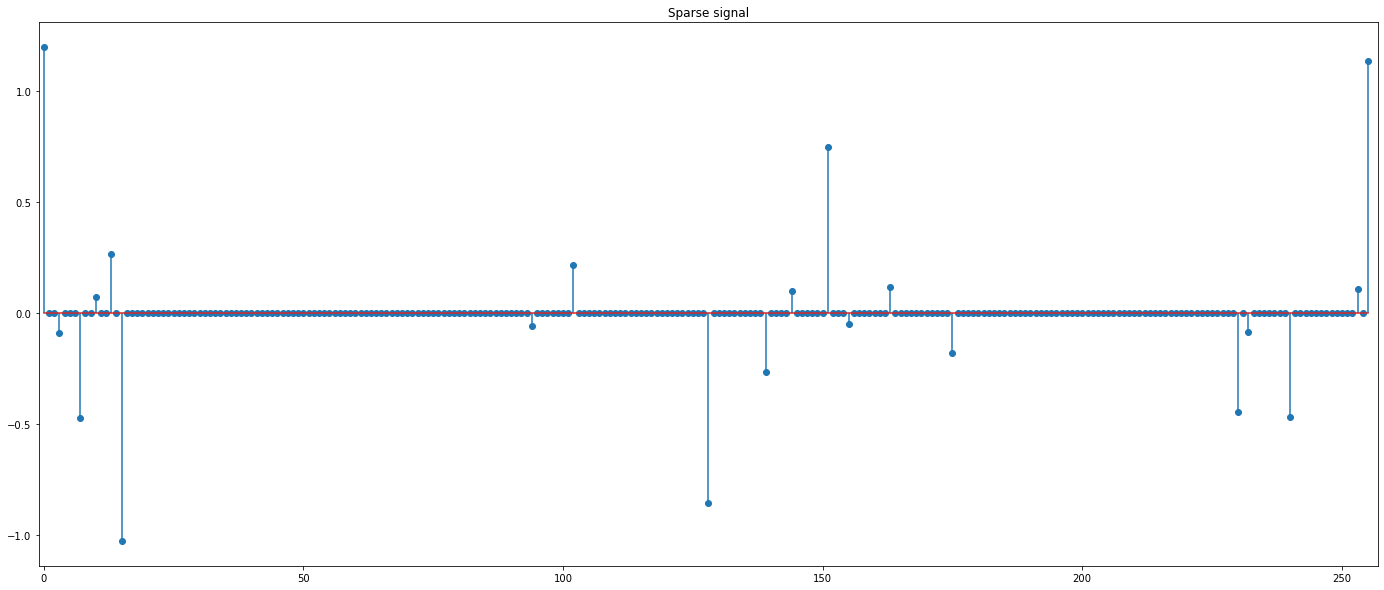

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 10))
plt.xlim(-1, A.shape[1] + 0.9)
plt.title("Sparse signal")
plt.stem(x)
plt.show()

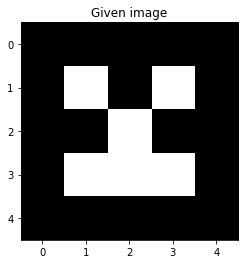

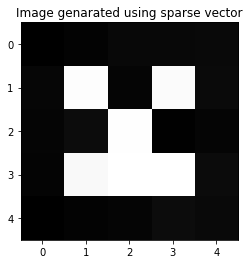

In [13]:
pred = np.matmul(A, x)

pred = pred.reshape((5, 5))
image = image.reshape((5, 5))

plt.imshow(image, cmap = 'gray')
plt.title('Given image')
plt.show()
plt.imshow(pred, cmap = 'gray')
plt.title('Image genarated using sparse vector')
plt.show()

In [8]:
import cv2

# np.save('/content/drive/MyDrive/Impulse_19/Task#2/Task#2_x.npy', x)
# cv2.imwrite('/content/drive/MyDrive/Impulse_19/Task#2/reconstructedImg.jpg', pred) 